In [1]:
import os
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf

PATH = "physionet.org/files/sleep-accel/1.0.0/heart_rate"

# Import Data

In [2]:
def get_data(file):
    data = pd.read_csv(PATH + "/" + file, ",", header=None, names=['second', 'bpm'])
    
    # remove duplicates
    data.drop_duplicates(keep='first', inplace=True) 
    
    # remove data before starting point
    data = data[data["second"] >= 0]
    
    # remove last 10 minutes (@10hz)
    data.drop(data.tail(100).index, inplace=True)
    
    # reset index
    data.reset_index(drop=True, inplace=True)
    
    
    
    max = data["second"].max()
    min = data["second"].min()

    tot_seconds = int(max - min)
       

    minutes_sample_rates = []
    minute = 0
    minute_count = 0
    
    for index, row in data.iterrows():
        second = row["second"]
        if second > (minute + 1) * 60:
            minutes_sample_rates.append(minute_count)
            minute_count = 0
            minute += 1

            while second > (minute + 1) * 60:
                minutes_sample_rates.append(minute_count)
                minute += 1
            
        minute_count += 1
    
    if minute_count > 0:
        minutes_sample_rates.append(minute_count)
    
    
    print(file, data.shape[0], tot_seconds, int(tot_seconds / 3600), len(minutes_sample_rates))

    plt.figure(figsize=(12,6))
    plt.plot(minutes_sample_rates)
    plt.show()
    
    return data

6220552_heartrate.txt 5775 29863 8 498


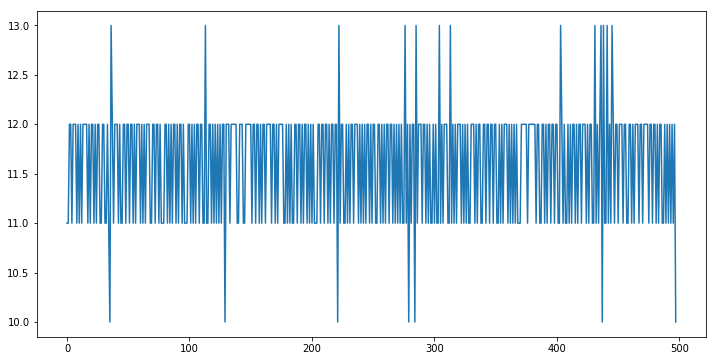

In [3]:
data = get_data('6220552_heartrate.txt')


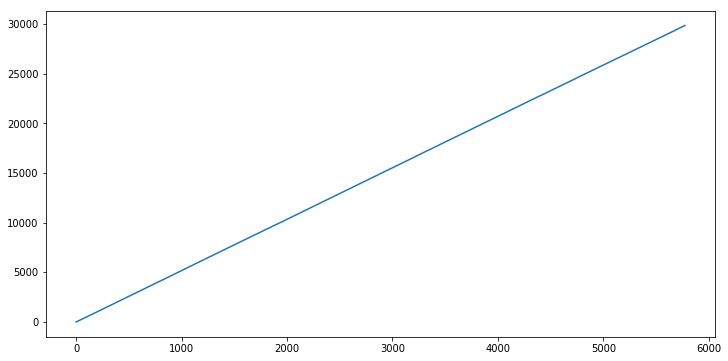

In [4]:
plt.figure(figsize=(12,6))
plt.plot(data["second"])
plt.show()

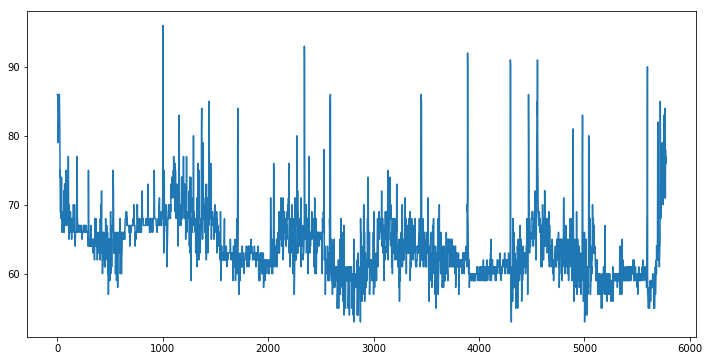

In [5]:
plt.figure(figsize=(12,6))
plt.plot(data["bpm"])
plt.show()

(5775,)


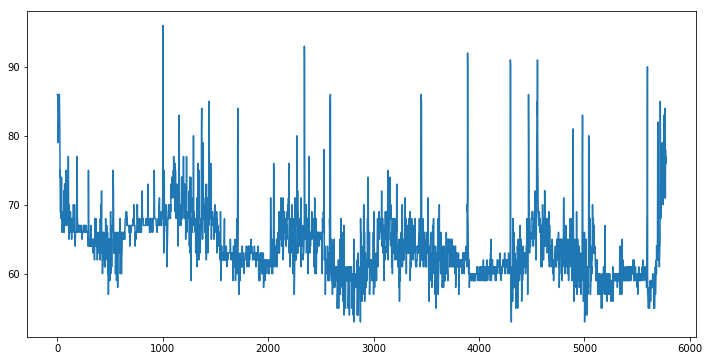

In [6]:
data.drop(['second'], axis=1, inplace=True)

X_train = data["bpm"].values

print(X_train.shape)

plt.figure(figsize=(12,6))
plt.plot(X_train)
plt.show()

# Normalize data

In [7]:
scaler = MinMaxScaler()
X_train = scaler.fit_transform(data)
X_train.shape

(5775, 1)

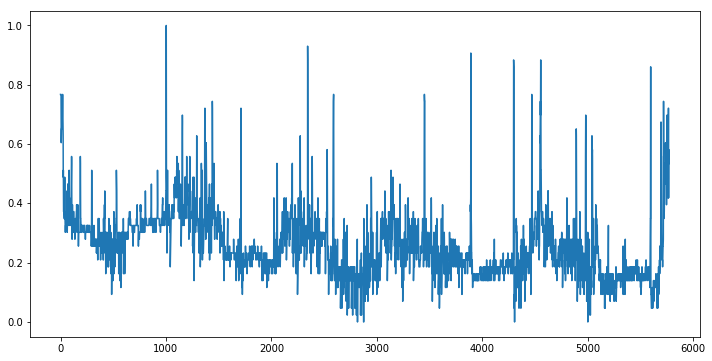

In [8]:
plt.figure(figsize=(12,6))
plt.plot(X_train)
plt.show()

In [9]:
X_train = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])
X_train.shape

(5775, 1, 1)

# Create Model

In [10]:
inputs = tf.keras.Input(shape=(X_train.shape[1], X_train.shape[2]))
L1 = tf.keras.layers.LSTM(16, activation='relu', return_sequences=True,
                  kernel_regularizer=tf.keras.regularizers.l2(0.00))(inputs)
L2 = tf.keras.layers.LSTM(4, activation='relu', return_sequences=False)(L1)
L3 = tf.keras.layers.RepeatVector(X_train.shape[1])(L2)
L4 = tf.keras.layers.LSTM(16, activation='relu', return_sequences=True)(L3)
L5 = tf.keras.layers.LSTM(4, activation='relu', return_sequences=True)(L4)
output = tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(X_train.shape[2]))(L5)

model = tf.keras.Model(inputs=inputs, outputs=output)


In [11]:
model.compile(optimizer='adam', loss='mae')

In [12]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 1, 1)]            0         
_________________________________________________________________
lstm (LSTM)                  (None, 1, 16)             1152      
_________________________________________________________________
lstm_1 (LSTM)                (None, 4)                 336       
_________________________________________________________________
repeat_vector (RepeatVector) (None, 1, 4)              0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 1, 16)             1344      
_________________________________________________________________
lstm_3 (LSTM)                (None, 1, 4)              336       
_________________________________________________________________
time_distributed (TimeDistri (None, 1, 1)              5     

In [13]:
nb_epoch = 100
batch_size = 10
history = model.fit(X_train, X_train, epochs=nb_epoch, batch_size=batch_size, validation_split=0.05).history

Train on 5486 samples, validate on 289 samples
Epoch 1/100
5486/5486 [==============================] - 6s 1ms/sample - loss: 0.1109 - val_loss: 0.1362
Epoch 2/100
5486/5486 [==============================] - 2s 299us/sample - loss: 0.0786 - val_loss: 0.1347
Epoch 3/100
5486/5486 [==============================] - 2s 287us/sample - loss: 0.0786 - val_loss: 0.1336
Epoch 4/100
5486/5486 [==============================] - 2s 293us/sample - loss: 0.0786 - val_loss: 0.1380
Epoch 5/100
5486/5486 [==============================] - 2s 304us/sample - loss: 0.0786 - val_loss: 0.1374
Epoch 6/100
5486/5486 [==============================] - 2s 343us/sample - loss: 0.0786 - val_loss: 0.1366
Epoch 7/100
5486/5486 [==============================] - 2s 303us/sample - loss: 0.0787 - val_loss: 0.1366
Epoch 8/100
5486/5486 [==============================] - 2s 326us/sample - loss: 0.0786 - val_loss: 0.1340
Epoch 9/100
5486/5486 [==============================] - 2s 342us/sample - loss: 0.0786 - val_loss:

5486/5486 [==============================] - 2s 293us/sample - loss: 0.0786 - val_loss: 0.1358
Epoch 77/100
5486/5486 [==============================] - 2s 297us/sample - loss: 0.0786 - val_loss: 0.1332
Epoch 78/100
5486/5486 [==============================] - 2s 309us/sample - loss: 0.0787 - val_loss: 0.1334
Epoch 79/100
5486/5486 [==============================] - 2s 379us/sample - loss: 0.0786 - val_loss: 0.1363
Epoch 80/100
5486/5486 [==============================] - 2s 319us/sample - loss: 0.0786 - val_loss: 0.1343
Epoch 81/100
5486/5486 [==============================] - 2s 292us/sample - loss: 0.0786 - val_loss: 0.1332
Epoch 82/100
5486/5486 [==============================] - 2s 320us/sample - loss: 0.0786 - val_loss: 0.1384
Epoch 83/100
5486/5486 [==============================] - 2s 336us/sample - loss: 0.0787 - val_loss: 0.1357
Epoch 84/100
5486/5486 [==============================] - 2s 294us/sample - loss: 0.0786 - val_loss: 0.1354
Epoch 85/100
5486/5486 [=================

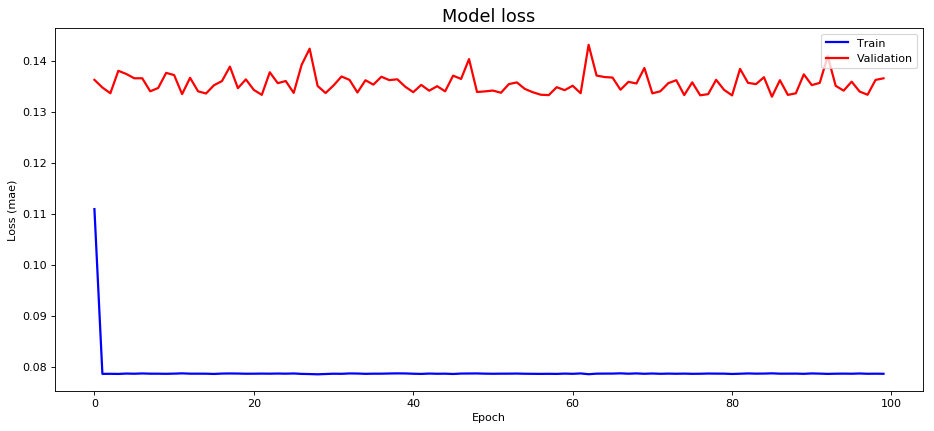

In [15]:
fig, ax = plt.subplots(figsize=(14, 6), dpi=80)
ax.plot(history['loss'], 'b', label='Train', linewidth=2)
ax.plot(history['val_loss'], 'r', label='Validation', linewidth=2)
ax.set_title('Model loss', fontsize=16)
ax.set_ylabel('Loss (mae)')
ax.set_xlabel('Epoch')
ax.legend(loc='upper right')
plt.show()
